In [1]:
%pwd

u'/Users/guojw/works/jrj/section_flagship'

In [202]:
import cPickle
import numpy as np
import pandas as pd
from dbstore import jrj_pg_db as db
from logger import logging
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from consts import get_idx_perf_sql, get_seq_perf_sql, get_stk_perf_sql, get_sec_stks_dt_sql, \
    df_idx_raw_pk, df_sec_raw_pk, df_stk_raw_pk, df_sec_stk_dt_raw_pk

In [5]:
logger = logging.getLogger(__name__)

In [6]:
idx_by_day = db.execute(get_idx_perf_sql)
logger.info('Query index data done, the number of data is {cnt}'.format(cnt=len(idx_by_day)))
sec_by_day = db.execute(get_seq_perf_sql)
logger.info('Query section data done, the number of data is {cnt}.'.format(cnt=len(sec_by_day)))
stk_by_day = db.execute(get_stk_perf_sql)
logger.info('Query stock data done, the number of data is {cnt}.'.format(cnt=len(stk_by_day)))
sec_stk_dt_rel = db.execute(get_sec_stks_dt_sql)
logger.info('Query section-stock-period data done, the number of data is {cnt}.'
            .format(cnt=len(sec_stk_dt_rel)))
# compose data-frames and write them to files for future use
df_idx = pd.DataFrame(idx_by_day, columns=['period', 'chg_idx']).set_index('period')
df_idx.to_pickle(df_idx_raw_pk)
df_sec = pd.DataFrame(sec_by_day, columns=['sec_code', 'period', 'chg_sec']).set_index('period')
df_sec.to_pickle(df_sec_raw_pk)
df_stk = pd.DataFrame(stk_by_day, columns=['stk_code', 'period', 'chg_stk']).set_index('period')
df_stk.to_pickle(df_stk_raw_pk)
df_sec_stk_dt = pd.DataFrame(sec_stk_dt_rel, columns=['sec_code', 'stk_code', 'period'])
df_sec_stk_dt.to_pickle(df_sec_stk_dt_raw_pk)

2017-03-22 19:40:04,723 - INFO - __main__ - Query index data done, the number of data is 540
2017-03-22 19:41:38,815 - INFO - __main__ - Query section data done, the number of data is 1182910.
2017-03-22 19:43:32,909 - INFO - __main__ - Query stock data done, the number of data is 1409921.
2017-03-22 19:54:41,929 - INFO - __main__ - Query section-stock-period data done, the number of data is 10517419.


In [39]:
def compute_sec_ind_by_day():
    """
    function to compute section indicators by period, those that
    doesn't need to group by section to stat.
    :return:
    """
    df_idx = pd.read_pickle(df_idx_raw_pk)
    df_sec = pd.read_pickle(df_sec_raw_pk)
    df_res = df_sec.join(df_idx, how='inner') \
        .assign(chg_sec_net=lambda df: (df['chg_sec'] - df['chg_idx']) / 100.0) \
        .assign(chg_sec_net_ln=lambda df: df.chg_sec_net.apply(np.log1p)) \
        .assign(prod_base=lambda df: df['chg_sec_net'] + 1) \
        .assign(idx=lambda df: df.prod_base.cumprod()) \
        .reset_index()
    df_res.to_csv(df_sec_ind_by_day_csv, index=None)

In [70]:
df_sec_ind_by_day_csv = 'data/df_sec_ind_by_day.csv'
df_sec_ind_stat_pk = 'data/df_sec_ind_stat.pickle'

In [41]:
compute_sec_ind_by_day()

In [42]:
pd.read_csv(df_sec_ind_by_day_csv).head()

period   sec_code  chg_sec  chg_idx  chg_sec_net  chg_sec_net_ln  \
0  2015-01-05  400100020   4.9619   3.0516     0.019103        0.018923   
1  2015-01-05  400100021   0.3837   3.0516    -0.026679       -0.027041   
2  2015-01-05  400100022   0.3837   3.0516    -0.026679       -0.027041   
3  2015-01-05  400100023   1.7058   3.0516    -0.013458       -0.013549   
4  2015-01-05  400100024   2.6552   3.0516    -0.003964       -0.003972   

   prod_base       idx  
0   1.019103  1.019103  
1   0.973321  0.991914  
2   0.973321  0.965451  
3   0.986542  0.952458  
4   0.996036  0.948682

In [54]:
def compute_sec_ind_stat():
    """
    function to compute section indicators that needs to stat group by section,
    this function depends on the output of COMPUTE_SEC_IND_BY_DAY().
    :return:
    """
    df_sec = pd.read_csv(df_sec_ind_by_day_csv)
    df_sec_std = df_sec \
        .loc[:, ['sec_code', 'chg_sec_net_ln', 'idx', 'period']] \
        .groupby('sec_code') \
        .agg({'chg_sec_net_ln': [np.mean, np.std],
              'idx': [np.mean, np.std],
              'period': [np.max]}) \
        .reset_index()
    # df_sec_std.columns = ['_'.join(col).strip('_') for col in df_sec.columns]
    df_sec_std.to_csv(df_sec_ind_stat_csv, index=None)

In [71]:
df_sec = pd.read_csv(df_sec_ind_by_day_csv)
df_sec_std = df_sec \
    .loc[:, ['sec_code', 'chg_sec_net_ln', 'idx', 'period']] \
    .groupby('sec_code') \
    .agg({'chg_sec_net_ln': [np.mean, np.std],
          'idx': [np.mean, np.std],
          'period': [np.max]}) \
    .reset_index()
df_sec_std.columns = ['_'.join(col).strip('_') for col in df_sec_std.columns]
df_sec_std.to_csv(df_sec_ind_stat_pk, index=None)

In [67]:
df_sec_std.head()

sec_code  chg_sec_net_ln_mean  chg_sec_net_ln_std       idx_mean  \
0  400100020             0.001466            0.028192   5.962411e+92   
1  400100021             0.001494            0.021617  1.555120e+136   
2  400100022             0.001494            0.021617  1.554537e+136   
3  400100023             0.002313            0.038278  1.123281e+113   
4  400100024             0.000722            0.023661  1.552352e+136   

         idx_std period_amax  
0   6.318390e+93  2015-10-21  
1  1.237963e+137  2017-03-22  
2  1.239509e+137  2017-03-22  
3  1.493894e+114  2016-01-20  
4  1.234840e+137  2017-03-22

In [72]:
def compute_stk_ind_by_day():
    """
    function to compute stock indicators by period, those that
    doesn't need to group by stock to stat.
    :return:
    """
    df_idx = pd.read_pickle(df_idx_raw_pk)
    df_stk = pd.read_pickle(df_stk_raw_pk)
    df_res = df_stk.join(df_idx, how='inner') \
        .assign(chg_stk_net=lambda df: (df['chg_stk'] - df['chg_idx']) / 100.0) \
        .assign(chg_stk_net_ln=lambda df: df.chg_stk_net.apply(np.log1p)) \
        .assign(prod_base=lambda df: df['chg_stk_net'] + 1) \
        .assign(idx=lambda df: df.prod_base.cumprod()) \
        .reset_index()
    df_res.to_csv(df_stk_ind_by_day_csv, index=None)

In [73]:
df_stk_ind_by_day_csv = 'data/df_stk_ind_by_day.csv'
df_stk_ind_stat_pk = 'data/df_stk_ind_stat.pickle'

In [78]:
compute_stk_ind_by_day()

TypeError: compute_stk_ind_by_day() takes no arguments (1 given)

In [79]:
pd.read_csv(df_stk_ind_by_day_csv).head()

period   stk_code  chg_stk  chg_idx  chg_stk_net  chg_stk_net_ln  \
0  2015-01-05  101000071  -0.6633   3.0516    -0.037149       -0.037857   
1  2015-01-05  101000072   0.3181   3.0516    -0.027335       -0.027716   
2  2015-01-05  101000073   6.1678   3.0516     0.031162        0.030686   
3  2015-01-05  101000076  -1.5137   3.0516    -0.045653       -0.046728   
4  2015-01-05  101000077   2.1912   3.0516    -0.008604       -0.008641   

   prod_base       idx  
0   0.962851  0.962851  
1   0.972665  0.936531  
2   1.031162  0.965716  
3   0.954347  0.921628  
4   0.991396  0.913698

In [80]:
def compute_stk_ind_stat():
    """
    function to compute stock indicators that needs to stat group by stocks,
    this function depends on the output of COMPUTE_STK_IND_BY_DAY().
    :return:
    """
    df_stk = pd.read_csv(df_stk_ind_by_day_csv)
    df_stk_std = df_stk \
        .loc[:, ['stk_code', 'chg_stk_net_ln']] \
        .groupby('stk_code') \
        .agg({'chg_stk_net_ln': [np.mean, np.std]}) \
        .reset_index()
    df_stk_std.columns = ['_'.join(col).strip('_') for col in df_stk_std.columns]
    df_stk_std.to_pickle(df_stk_ind_stat_pk)

In [81]:
compute_stk_ind_stat()

In [82]:
pd.read_pickle(df_stk_ind_stat_pk).head()

stk_code  chg_stk_net_ln_mean  chg_stk_net_ln_std
0  101000001             0.000672            0.021179
1  101000002             0.001609            0.037431
2  101000003            -0.000326            0.012104
3  101000005             0.000727            0.026003
4  101000010             0.002448            0.034728

In [85]:
df_sec_ind_roll_stks_pk = 'data/df_sec_ind_roll_stks.pickle'

In [86]:
def compute_sec_ind_roll_stks_by_day():
    """
    function to merge section with stock performance to compute the average raising percent.
    this function depends on the outputs of COMPUTE_SEC_IND_BY_DAY() & COMPUTE_STK_IND_BY_DAY().
    :return:
    """
    df_sec_stk_dt = pd.read_pickle(df_sec_stk_dt_raw_pk)
    df_stk = pd.read_csv(df_stk_ind_by_day_csv)
    df_res = pd.merge(df_sec_stk_dt,
                      df_stk.loc[:, ['stk_code', 'period', 'chg_stk_net']],
                      on=['stk_code', 'period']) \
               .assign(stk_inc=lambda df: (df['chg_stk_net'] > 0).astype(int)) \
               .groupby(['stk_code', 'period']) \
               .agg({'stk_inc': np.mean}) \
               .reset_index()
    df_res.columns = ['_'.join(col).strip('_') for col in df_res.columns]
    df_res.to_pickle(df_sec_ind_roll_stks_pk)

In [87]:
compute_sec_ind_roll_stks_by_day()

In [89]:
df_sec_ind_by_day = pd.read_csv(df_sec_ind_by_day_csv)
# df_sec_ind_stat = pd.read_pickle(df_sec_ind_stat_pk)
df_sec_ind_roll_stks = pd.read_pickle(df_sec_ind_roll_stks_pk)

In [90]:
df_sec_ind_stat_pk

'data/df_sec_ind_stat.pickle'

In [92]:
def compute_sec_ind_stat():
    """
    function to compute section indicators that needs to stat group by section,
    this function depends on the output of COMPUTE_SEC_IND_BY_DAY().
    :return:
    """
    df_sec = pd.read_csv(df_sec_ind_by_day_csv)
    df_sec_std = df_sec \
        .loc[:, ['sec_code', 'chg_sec_net_ln', 'idx', 'period']] \
        .groupby('sec_code') \
        .agg({'chg_sec_net_ln': [np.mean, np.std],
              'idx': [np.mean, np.std],
              'period': [np.max]}) \
        .reset_index()
    df_sec_std.columns = ['_'.join(col).strip('_') for col in df_sec_std.columns]
    df_sec_std.to_pickle(df_sec_ind_stat_pk)

In [93]:
compute_sec_ind_stat()

In [97]:
len(set(list(pd.read_pickle(df_sec_ind_stat_pk).sec_code)))

766

In [98]:
df_sec_ind_by_day.shape, df_sec_ind_stat.shape, df_sec_ind_roll_stks.shape

((306726, 8), (768, 6), (0, 3))

In [99]:
df_sec_stk_dt = pd.read_pickle(df_sec_stk_dt_raw_pk)
df_stk = pd.read_csv(df_stk_ind_by_day_csv)

In [100]:
df_sec_stk_dt.shape, df_stk.shape

((10517419, 3), (1409921, 8))

In [102]:
df_sec_stk_dt.head()

sec_code   stk_code     period
0  400130157  101004816 2017-12-29
1  400130157  101004816 2017-12-28
2  400130157  101004816 2017-12-27
3  400130157  101004816 2017-12-26
4  400130157  101004816 2017-12-25

In [107]:
df_stk.tail()

period   stk_code  chg_stk  chg_idx  chg_stk_net  chg_stk_net_ln  \
1409916  2017-03-22  101002614  -0.8316  -0.4701    -0.003615       -0.003622   
1409917  2017-03-22  101002615   0.8824  -0.4701     0.013525        0.013434   
1409918  2017-03-22  101002618   0.5889  -0.4701     0.010590        0.010534   
1409919  2017-03-22  101002619  -1.8024  -0.4701    -0.013323       -0.013413   
1409920  2017-03-22  101002620  -1.0119  -0.4701    -0.005418       -0.005433   

         prod_base  idx  
1409916   0.996385  inf  
1409917   1.013525  inf  
1409918   1.010590  inf  
1409919   0.986677  inf  
1409920   0.994582  inf

In [109]:
df_stk.dtypes

period             object
stk_code            int64
chg_stk           float64
chg_idx           float64
chg_stk_net       float64
chg_stk_net_ln    float64
prod_base         float64
idx               float64
dtype: object

In [111]:
df_sec_ind_by_day = pd.read_pickle(df_sec_ind_by_day_pk)
df_sec_ind_stat = pd.read_pickle(df_sec_ind_stat_pk)
df_sec_ind_roll_stks = pd.read_pickle(df_sec_ind_roll_stks_pk)

In [112]:
df_sec_ind_by_day.shape

(108445, 8)

In [113]:
df_sec_ind_stat.shape

(274, 6)

In [114]:
df_sec_ind_roll_stks.shape

(1293241, 3)

In [115]:
df_sec_ind_by_day.head()

period   sec_code  chg_sec  chg_idx  chg_sec_net  chg_sec_net_ln  \
0 2015-01-05  400129627   1.1783   3.0516    -0.018733       -0.018911   
1 2015-01-05  400129625   2.4267   3.0516    -0.006249       -0.006269   
2 2015-01-05  400129516   2.6239   3.0516    -0.004277       -0.004286   
3 2015-01-05  400129514  -0.0775   3.0516    -0.031291       -0.031791   
4 2015-01-05  400129499   0.5905   3.0516    -0.024611       -0.024919   

   prod_base       idx  
0   0.981267  0.981267  
1   0.993751  0.975135  
2   0.995723  0.970964  
3   0.968709  0.940582  
4   0.975389  0.917433

In [116]:
df_sec_ind_stat.head()

sec_code  chg_sec_net_ln_mean  chg_sec_net_ln_std      idx_mean  \
0  400121926             0.000915            0.012741  3.649917e+40   
1  400121929             0.001210            0.011697  3.562526e+40   
2  400121934             0.001321            0.011233  3.562298e+40   
3  400121935             0.000649            0.013238  3.557233e+40   
4  400121936             0.001047            0.015227  3.555459e+40   

        idx_std period_amax  
0  1.549235e+41  2017-03-22  
1  1.535297e+41  2017-03-22  
2  1.534993e+41  2017-03-22  
3  1.530381e+41  2017-03-22  
4  1.527557e+41  2017-03-22

In [117]:
df_sec_ind_roll_stks.head()

s_t_k___c_o_d_e p_e_r_i_o_d  s_t_k___i_n_c
0        101000001  2015-01-05              0
1        101000001  2015-01-06              0
2        101000001  2015-01-07              0
3        101000001  2015-01-08              1
4        101000001  2015-01-09              1

In [126]:
df_idx_raw_pk = 'data/df_idx_raw.pickle'
df_sec_raw_pk = 'data/df_sec_raw.pickle'
df_stk_raw_pk = 'data/df_stk_raw.pickle'
df_sec_stk_dt_raw_pk = 'data/df_sec_stk_dt_raw.pickle'

df_sec_ind_by_day_pk = 'data/df_sec_ind_by_day.pickle'
df_sec_ind_stat_pk = 'data/df_sec_ind_stat.pickle'

df_stk_ind_by_day_pk = 'data/df_stk_ind_by_day.pickle'
df_stk_ind_stat_pk = 'data/df_stk_ind_stat.pickle'
df_sec_ind_roll_stks_pk = 'data/df_sec_ind_roll_stks.pickle'

df_sec_stk_dt = pd.read_pickle(df_sec_stk_dt_raw_pk)
df_stk = pd.read_pickle(df_stk_ind_by_day_pk)

In [127]:
df_res = pd.merge(df_sec_stk_dt,
                  df_stk.loc[:, ['stk_code', 'period', 'chg_stk_net']],
                  on=['stk_code', 'period']) \
           .assign(stk_inc=lambda df: (df.chg_stk_net > 0).astype(np.float)) \
           .groupby(['sec_code', 'period']) \
           .agg({'stk_inc': np.mean}) \
           .reset_index()

In [128]:
df_res.head()

sec_code     period   stk_inc
0  400121926 2015-12-07  0.636364
1  400121926 2015-12-08  0.272727
2  400121926 2015-12-09  0.363636
3  400121926 2015-12-10  0.090909
4  400121926 2015-12-11  0.090909

In [125]:
len(set(df_res.sec_code.tolist()))

269

In [129]:
df_sec_ind_by_day = pd.read_pickle(df_sec_ind_by_day_pk)
df_sec_ind_stat = pd.read_pickle(df_sec_ind_stat_pk)
df_sec_ind_roll_stks = pd.read_pickle(df_sec_ind_roll_stks_pk)

In [130]:
df_res = pd.merge(
    pd.merge(
        df_sec_ind_by_day,
        df_sec_ind_stat,
        on='sec_code'),
    df_sec_ind_roll_stks,
    on='sec_code'
)

In [132]:
df_res.shape

(54478206, 15)

In [135]:
df_sec_ind_by_day.shape, df_sec_ind_roll_stks.shape

((108445, 8), (131038, 3))

In [136]:
df_sec_ind_stat.shape

(274, 6)

In [157]:
df_sec_res_pk = 'data/df_sec_res.pickle'

In [186]:
df_res = pd.read_pickle(df_sec_res_pk)

In [189]:
len(set(df_res.sec_code.tolist()))

269

In [190]:
df_res.head()

period   sec_code   chg_sec  chg_sec_ln  stk_inc_mean  chg_sec_mean  \
0 2015-01-05  400129627 -0.018733   -0.018911      0.058824      0.001232   
1 2015-01-06  400129627  0.025990    0.025658      1.000000      0.001232   
2 2015-01-07  400129627 -0.009223   -0.009266      0.176471      0.001232   
3 2015-01-08  400129627  0.029563    0.029134      1.000000      0.001232   
4 2015-01-09  400129627 -0.004464   -0.004474      0.352941      0.001232   

   chg_sec_std period_max last_period is_last  
0     0.014476 2017-03-22  2015-01-05   False  
1     0.014476 2017-03-22  2015-01-05   False  
2     0.014476 2017-03-22  2015-01-06   False  
3     0.014476 2017-03-22  2015-01-07   False  
4     0.014476 2017-03-22  2015-01-08   False

In [191]:
def label_period_by_sec(df_sec):
    """
    function to label the period as increase, continue, decrease,
    this function accept data-frame of particular section and output the labeled data-frame.
    :param df_sec: data-frame-by-section that composed from compose_data.py
    :return: labeled data-frame of section infos by day.
    """
    df_sec_labeled = df_sec \
        .sort_values(by='period', axis=0, ascending=True) \
        .assign(idx=lambda df: (df.chg_sec + 1).cumprod()) \
        .assign(is_inc=lambda df: (df.stk_inc_mean > SEC_INC_PCT)
                & (df.chg_sec_ln > (df.chg_sec_mean + df.chg_sec_std * SEC_INC_VAR))) \
        .assign(is_desc=lambda df:
                df.chg_sec_ln < (df.chg_sec_mean - df.chg_sec_std * SEC_DESC_VAR)) \
        .assign(is_cont=lambda df: df.stk_inc_mean > SEC_CONT_PCT) \
        .set_index('period')
    idx_var = np.std(df_sec_labeled.idx)
    return df_sec_labeled, idx_var

In [192]:
df_test = df_res[df_res['sec_code'] == 400129627]

In [193]:
df_test.shape, df_test.head()

((539, 10),
       period   sec_code   chg_sec  chg_sec_ln  stk_inc_mean  chg_sec_mean  \
 0 2015-01-05  400129627 -0.018733   -0.018911      0.058824      0.001232   
 1 2015-01-06  400129627  0.025990    0.025658      1.000000      0.001232   
 2 2015-01-07  400129627 -0.009223   -0.009266      0.176471      0.001232   
 3 2015-01-08  400129627  0.029563    0.029134      1.000000      0.001232   
 4 2015-01-09  400129627 -0.004464   -0.004474      0.352941      0.001232   
 
    chg_sec_std period_max last_period is_last  
 0     0.014476 2017-03-22  2015-01-05   False  
 1     0.014476 2017-03-22  2015-01-05   False  
 2     0.014476 2017-03-22  2015-01-06   False  
 3     0.014476 2017-03-22  2015-01-07   False  
 4     0.014476 2017-03-22  2015-01-08   False  )

In [195]:
SEC_INC_PCT = 0.5
SEC_INC_VAR = 0.5
SEC_DESC_VAR = 0.5
SEC_CONT_PCT = 0.5
SEC_INC_ESTABLISH_VAR = 0.5
df_test_labeled, idx_var = label_period_by_sec(df_test)

In [196]:
df_test_labeled.shape

(539, 13)

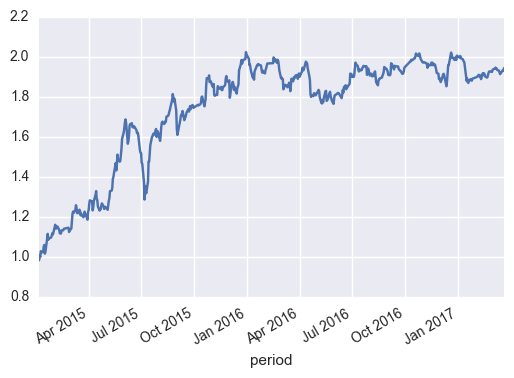

In [212]:
df_test_labeled.idx.plot()

In [207]:
idx_var

0.2761941346374198

In [231]:
def find_raising_period_by_sec(df_sec_labeled, idx_var):
    """
    CORE FUNCTION to find active period by section, this function accept the output
    labeled data-frame of particular section and return all appreciate raising periods.
    :param df_sec_labeled: labeled-data-frame-by-section that produced by LABEL_PERIOD_BY_SEC().
    :return: data-frame that records all appreciate raising periods.
    """
    idx_std_base = idx_var * SEC_INC_ESTABLISH_VAR
    res_periods, temp_periods = [], []
    last_period, last_item = None, pd.Series()
    for period, item in df_sec_labeled.iterrows():
        # deal with raise period
        if item.get('is_inc', False):
            if temp_periods:
                temp_periods.append(period)
            # if start raise, check whether last period is continue
            elif last_item.get('is_cont', False):
                temp_periods.extend([last_period, period])
            else:
                temp_periods.append(period)
        # deal with continuous raise period
        elif item.get('is_cont', False):
            if temp_periods:
                temp_periods.append(period)
        # deal with decrease period OR last period
        # TAKE ATTENTION: the follow if-condition is not else alternative of before conditions,
        # particular line could qualify double conditions and do the twice manipulations.
        if item.get('is_desc', False) or item.get('is_last', False):
            # if temp periods hold data, check whether its raising percent is appreciate
            if temp_periods:
                if len(temp_periods) == 1 and last_item.get('chg_sec', -99) > idx_std_base:
                    res_periods.append([last_period, last_period, last_item['chg_sec']])
                else:
                    start_dt, end_dt = temp_periods[0], temp_periods[-1]
                    # start index store in the day before
                    start_dt_before = df_sec_labeled.at[start_dt, 'last_period']
                    start_idx = df_sec_labeled.at[start_dt_before, 'idx']
                    end_idx = df_sec_labeled.at[end_dt, 'idx']
                    raise_pct = (end_idx * 1.0 / start_idx - 1)
                    # if the raise percent bigger than half index standard error,
                    # then accept this period as raising part.
                    if raise_pct > idx_std_base:
                        res_periods.append([start_dt, end_dt, raise_pct])
                # clear temp periods
                temp_periods = []
        # assign current period and item to last at the end
        last_period, last_item = period, item
    df_res = pd.DataFrame(res_periods, columns=['start', 'end', 'cum_inc'])
    return df_res

In [232]:
find_raising_period_by_sec(df_test_labeled, idx_var)

start        end   cum_inc
0 2015-05-05 2015-05-18  0.189701
1 2015-07-10 2015-07-23  0.217048

In [219]:
df_test_labeled.head()

sec_code   chg_sec  chg_sec_ln  stk_inc_mean  chg_sec_mean  \
period                                                                    
2015-01-05  400129627 -0.018733   -0.018911      0.058824      0.001232   
2015-01-06  400129627  0.025990    0.025658      1.000000      0.001232   
2015-01-07  400129627 -0.009223   -0.009266      0.176471      0.001232   
2015-01-08  400129627  0.029563    0.029134      1.000000      0.001232   
2015-01-09  400129627 -0.004464   -0.004474      0.352941      0.001232   

            chg_sec_std period_max last_period is_last       idx is_inc  \
period                                                                    
2015-01-05     0.014476 2017-03-22  2015-01-05   False  0.981267  False   
2015-01-06     0.014476 2017-03-22  2015-01-05   False  1.006770   True   
2015-01-07     0.014476 2017-03-22  2015-01-06   False  0.997485  False   
2015-01-08     0.014476 2017-03-22  2015-01-07   False  1.026973   True   
2015-01-09     0.014476 2017-03-22  2015-01-08   False  1.022389  False   

           is_desc is_cont  
period                      
2015-01-05    True   False  
2015-01-06   False    True  
2015-01-07    True   False  
2015-01-08   False    True  
2015-01-09   False   False

In [230]:
pd.read_pickle(df_stk_ind_by_day_pk).head()

period   stk_code  chg_stk  chg_idx  chg_stk_net  chg_stk_net_ln
0 2015-01-05  101000001   1.1306   3.0516    -0.019210       -0.019397
1 2015-01-05  101000002  -1.2931   3.0516    -0.043447       -0.044419
2 2015-01-05  101000003   1.1364   3.0516    -0.019152       -0.019338
3 2015-01-05  101000005   7.2662   3.0516     0.042146        0.041282
4 2015-01-05  101000010   0.7707   3.0516    -0.022809       -0.023073

In [233]:
SEC_INC_ESTABLISH_STD = 3

In [234]:
def find_raising_period_by_sec(df_sec_labeled, idx_var):
    """
    CORE FUNCTION to find active period by section, this function accept the output
    labeled data-frame of particular section and return all appreciate raising periods.
    :param df_sec_labeled: labeled-data-frame-by-section that produced by LABEL_PERIOD_BY_SEC().
    :return: data-frame that records all appreciate raising periods.
    """
    # idx_std_base = idx_var * SEC_INC_ESTABLISH_VAR
    res_periods, temp_periods = [], []
    last_period, last_item = None, pd.Series()
    for period, item in df_sec_labeled.iterrows():
        # deal with raise period
        if item.get('is_inc', False):
            if temp_periods:
                temp_periods.append(period)
            # if start raise, check whether last period is continue
            elif last_item.get('is_cont', False):
                temp_periods.extend([last_period, period])
            else:
                temp_periods.append(period)
        # deal with continuous raise period
        elif item.get('is_cont', False):
            if temp_periods:
                temp_periods.append(period)
        # deal with decrease period OR last period
        # TAKE ATTENTION: the follow if-condition is not else alternative of before conditions,
        # particular line could qualify double conditions and do the twice manipulations.
        if item.get('is_desc', False) or item.get('is_last', False):
            # if temp periods hold data, check whether its raising percent is appreciate
            if temp_periods:
                if len(temp_periods) == 1 and last_item.get('chg_sec', -99) > \
                                item.get('chg_sec_std', -99) * SEC_INC_ESTABLISH_STD:
                    res_periods.append([last_period, last_period, last_item['chg_sec']])
                else:
                    start_dt, end_dt = temp_periods[0], temp_periods[-1]
                    # start index store in the day before
                    start_dt_before = df_sec_labeled.at[start_dt, 'last_period']
                    start_idx = df_sec_labeled.at[start_dt_before, 'idx']
                    end_idx = df_sec_labeled.at[end_dt, 'idx']
                    raise_pct = (end_idx * 1.0 / start_idx - 1)
                    # if the raise percent bigger than half index standard error,
                    # then accept this period as raising part.
                    if raise_pct > item.get('chg_sec_std', -99) * SEC_INC_ESTABLISH_STD:
                        res_periods.append([start_dt, end_dt, raise_pct])
                # clear temp periods
                temp_periods = []
        # assign current period and item to last at the end
        last_period, last_item = period, item
    df_res = pd.DataFrame(res_periods, columns=['start', 'end', 'cum_inc'])
    return df_res

In [236]:
df_sec_raising_period = \
    find_raising_period_by_sec(df_test_labeled, idx_var)

In [237]:
def main(df_sec_raising_period, df_stk_by_day):
    temp_dct = {}
    for idx, item in df_sec_raising_period.iterrows():
        start, end, cum_inc = item
        df_stk_incs = df_stk_by_day \
            .loc[(df_stk_by_day.period >= start) & (df_stk_by_day.period <= end)] \
            .loc[:, ['stk_code', 'chg_stk_net']] \
            .groupby('stk_code') \
            .sum() \
            .sort_values(by='chg_stk_net', ascending=False)
        top10_stks = df_stk_incs.index[:10].tolist()
        temp_dct[idx] = top10_stks
    df_top10_stks = pd.DataFrame.from_dict(temp_dct).T \
                      .rename(columns=lambda i: 'sort_{i}'.format(i=i))
    df_merge_top10_stks = pd.concat([df_sec_raising_period, df_top10_stks], axis=1)
    return df_merge_top10_stks

In [238]:
df_stk_by_day = pd.read_pickle(df_stk_ind_by_day_pk)

In [239]:
df_sec_raising_period

start        end   cum_inc
0  2015-01-08 2015-01-14  0.060584
1  2015-01-16 2015-01-20  0.097493
2  2015-01-28 2015-02-02  0.048707
3  2015-02-27 2015-03-10  0.119353
4  2015-03-31 2015-04-03  0.081589
5  2015-04-10 2015-04-14  0.065187
6  2015-05-05 2015-05-18  0.189701
7  2015-05-20 2015-05-21  0.055205
8  2015-05-29 2015-06-02  0.067600
9  2015-06-09 2015-06-11  0.057291
10 2015-07-10 2015-07-23  0.217048
11 2015-08-04 2015-08-10  0.053484
12 2015-09-07 2015-09-11  0.074136
13 2015-10-20 2015-10-23  0.080578
14 2015-12-03 2015-12-07  0.044128
15 2015-12-15 2015-12-22  0.092184
16 2016-08-16 2016-08-26  0.049301
17 2016-09-29 2016-10-25  0.050288
18 2016-12-13 2016-12-20  0.090915

In [240]:
df_stk_by_day.head()

period   stk_code  chg_stk  chg_idx  chg_stk_net  chg_stk_net_ln
0 2015-01-05  101000001   1.1306   3.0516    -0.019210       -0.019397
1 2015-01-05  101000002  -1.2931   3.0516    -0.043447       -0.044419
2 2015-01-05  101000003   1.1364   3.0516    -0.019152       -0.019338
3 2015-01-05  101000005   7.2662   3.0516     0.042146        0.041282
4 2015-01-05  101000010   0.7707   3.0516    -0.022809       -0.023073

In [241]:
main(df_sec_raising_period, df_stk_by_day)

start        end   cum_inc     sort_0     sort_1     sort_2  \
0  2015-01-08 2015-01-14  0.060584  101002679  101004707  101004492   
1  2015-01-16 2015-01-20  0.097493  101000277  101004173  101000818   
2  2015-01-28 2015-02-02  0.048707  101002794  101004714  101004616   
3  2015-02-27 2015-03-10  0.119353  101004629  101004724  101003344   
4  2015-03-31 2015-04-03  0.081589  101001785  101001677  101001900   
5  2015-04-10 2015-04-14  0.065187  101000705  101000651  101000033   
6  2015-05-05 2015-05-18  0.189701  101004291  101002821  101004223   
7  2015-05-20 2015-05-21  0.055205  101002356  101004184  101004448   
8  2015-05-29 2015-06-02  0.067600  101000243  101004327  101003190   
9  2015-06-09 2015-06-11  0.057291  101000357  101002571  101004671   
10 2015-07-10 2015-07-23  0.217048  101004371  101003277  101001554   
11 2015-08-04 2015-08-10  0.053484  101001990  101002092  101002539   
12 2015-09-07 2015-09-11  0.074136  101001735  101004371  101000978   
13 2015-10-20 2015-10-23  0.080578  101002275  101001783  101001898   
14 2015-12-03 2015-12-07  0.044128  101003218  101003255  101002525   
15 2015-12-15 2015-12-22  0.092184  101000471  101002565  101004313   
16 2016-08-16 2016-08-26  0.049301  101004461  101004251  101004406   
17 2016-09-29 2016-10-25  0.050288  101003428  101004658  101004557   
18 2016-12-13 2016-12-20  0.090915  101004705  101017665  101004386   

       sort_3     sort_4     sort_5     sort_6     sort_7     sort_8  \
0   101004650  101004405  101002253  101003124  101002527  101002077   
1   101001861  101002679  101001979  101004305  101002517  101002370   
2   101004488  101004312  101003484  101004150  101004524  101004585   
3   101003307  101004512  101004473  101004127  101000833  101004402   
4   101002799  101004644  101002359  101004325  101001901  101004132   
5   101002170  101001139  101000380  101004644  101001021  101000543   
6   101004511  101004723  101003288  101004343  101002641  101004549   
7   101001258  101004340  101001859  101002738  101000971  101004291   
8   101000432  101002231  101000638  101000964  101002070  101004554   
9   101002671  101004664  101003100  101001385  101003095  101002966   
10  101002915  101002266  101001903  101002671  101000871  101002753   
11  101000945  101001162  101000214  101002976  101004491  101001830   
12  101000846  101000681  101000909  101000474  101001447  101001051   
13  101002742  101000046  101002739  101000316  101000956  101001946   
14  101003136  101002803  101000670  101004349  101002776  101001588   
15  101004487  101004238  101001224  101004749  101004398  101004742   
16  101004659  101004552  101004220  101004424  101004439  101004399   
17  101004633  101004394  101004621  101004408  101004170  101003392   
18  101004599  101004583  101004665  101016659  101005300  101005488   

       sort_9  
0   101002548  
1   101002971  
2   101004222  
3   101000911  
4   101004580  
5   101002449  
6   101004495  
7   101002588  
8   101004453  
9   101004327  
10  101004609  
11  101003485  
12  101003344  
13  101002648  
14  101002449  
15  101002951  
16  101004457  
17  101004758  
18  101004809

In [242]:
df_temp

NameError: name 'df_temp' is not defined

In [253]:
df_stk_incs = df_stk_by_day \
    .loc[:, ['stk_code', 'chg_stk_net']] \
    .groupby('stk_code') \
    .sum() \
    .reset_index() \
    .sort_values(by='chg_stk_net', ascending=False) \
    .assign(stk_cnt=lambda df: df.shape[0]) \
    .assign(ranks=lambda df: range(df.stk_cnt[0])) \
    .assign(rank_pct=lambda df: df.ranks * 1.0 / df.stk_cnt) \
    .assign(score=lambda df: np.linspace(1, 0, df.stk_cnt[0])) \
    .assign(flags=lambda df: (df.rank_pct <= 0.3) & (df.ranks <= 9))

In [254]:
df_stk_incs

stk_code  chg_stk_net  stk_cnt  ranks  rank_pct     score  flags
3095  101004777     3.152471     3262      0  0.000000  1.000000   True
3073  101004741     2.872843     3262      1  0.000307  0.999693   True
2833  101004349     2.834560     3262      2  0.000613  0.999387   True
2958  101004524     2.775353     3262      3  0.000920  0.999080   True
2837  101004353     2.737353     3262      4  0.001226  0.998773   True
2946  101004495     2.723550     3262      5  0.001533  0.998467   True
2989  101004586     2.710853     3262      6  0.001839  0.998160   True
2814  101004325     2.665511     3262      7  0.002146  0.997853   True
3051  101004697     2.640706     3262      8  0.002452  0.997547   True
2821  101004334     2.618269     3262      9  0.002759  0.997240   True
2922  101004462     2.609955     3262     10  0.003066  0.996933  False
3060  101004714     2.608312     3262     11  0.003372  0.996627  False
2916  101004455     2.600431     3262     12  0.003679  0.996320  False
3084  101004760     2.556802     3262     13  0.003985  0.996013  False
3071  101004737     2.552687     3262     14  0.004292  0.995707  False
3005  101004609     2.526995     3262     15  0.004598  0.995400  False
2954  101004511     2.489227     3262     16  0.004905  0.995094  False
2768  101004241     2.465464     3262     17  0.005212  0.994787  False
3090  101004770     2.449711     3262     18  0.005518  0.994480  False
2783  101004285     2.438995     3262     19  0.005825  0.994174  False
1497  101001886     2.437143     3262     20  0.006131  0.993867  False
2983  101004580     2.423482     3262     21  0.006438  0.993560  False
292   101000348     2.422505     3262     22  0.006744  0.993254  False
2816  101004327     2.421672     3262     23  0.007051  0.992947  False
3021  101004629     2.403162     3262     24  0.007357  0.992640  False
2241  101002803     2.392168     3262     25  0.007664  0.992334  False
2835  101004351     2.380828     3262     26  0.007971  0.992027  False
3063  101004723     2.375826     3262     27  0.008277  0.991720  False
1810  101002284     2.371058     3262     28  0.008584  0.991414  False
3044  101004670     2.336524     3262     29  0.008890  0.991107  False
...         ...          ...      ...    ...       ...       ...    ...
1100  101001236    -0.348227     3262   3232  0.990803  0.008893  False
1254  101001463    -0.349481     3262   3233  0.991110  0.008586  False
1076  101001211    -0.351158     3262   3234  0.991416  0.008280  False
1690  101002145    -0.366701     3262   3235  0.991723  0.007973  False
1491  101001880    -0.376509     3262   3236  0.992029  0.007666  False
705   101000792    -0.381313     3262   3237  0.992336  0.007360  False
642   101000728    -0.386292     3262   3238  0.992643  0.007053  False
2369  101002977    -0.386430     3262   3239  0.992949  0.006746  False
27    101000041    -0.403571     3262   3240  0.993256  0.006440  False
2183  101002734    -0.412169     3262   3241  0.993562  0.006133  False
731   101000821    -0.412604     3262   3242  0.993869  0.005826  False
155   101000184    -0.416098     3262   3243  0.994175  0.005520  False
1039  101001169    -0.425474     3262   3244  0.994482  0.005213  False
335   101000398    -0.429601     3262   3245  0.994788  0.004906  False
1135  101001273    -0.438976     3262   3246  0.995095  0.004600  False
2051  101002578    -0.439058     3262   3247  0.995402  0.004293  False
259   101000309    -0.441751     3262   3248  0.995708  0.003987  False
631   101000716    -0.454389     3262   3249  0.996015  0.003680  False
1649  101002056    -0.520903     3262   3250  0.996321  0.003373  False
802   101000901    -0.525972     3262   3251  0.996628  0.003067  False
1241  101001437    -0.543273     3262   3252  0.996934  0.002760  False
814   101000915    -0.568746     3262   3253  0.997241  0.002453  False
2128  101002670    -0.588931     3262   3254  0.997548  0.002147  False
1278  101001511    -0.592926     3262   3255  0

In [255]:
res_df_scores_pk = 'data/res_df_scores.pickle'

In [256]:
df_res = pd.read_pickle(res_df_scores_pk)

In [257]:
df_res.shape

(825942, 3)

In [259]:
df_res.head()

stk_code     score   sec_code
0  101004138  6.069615  400121926
1  101002751  5.982349  400121926
2  101004132  5.947096  400121926
3  101002433  5.902019  400121926
4  101002986  5.898168  400121926

In [264]:
df_res[df_res['sec_code'] == 400130017]

stk_code     score   sec_code
708875  101001266  2.916815  400130017
708876  101004695  2.916651  400130017
708877  101001632  2.890812  400130017
708878  101000244  2.852007  400130017
708879  101000904  2.822663  400130017
708880  101000005  2.801411  400130017
708881  101001193  2.799991  400130017
708882  101001453  2.799498  400130017
708883  101000728  2.796640  400130017
708884  101000158  2.794525  400130017
708885  101002608  2.780950  400130017
708886  101002603  2.775696  400130017
708887  101000224  2.771813  400130017
708888  101000756  2.742191  400130017
708889  101001106  2.741185  400130017
708890  101000774  2.734569  400130017
708891  101001055  2.724815  400130017
708892  101002787  2.723830  400130017
708893  101000720  2.723807  400130017
708894  101002458  2.720288  400130017
708895  101003175  2.718407  400130017
708896  101000820  2.711483  400130017
708897  101001915  2.710351  400130017
708898  101003171  2.710114  400130017
708899  101002620  2.705783  400130017
708900  101000334  2.697588  400130017
708901  101002315  2.694187  400130017
708902  101000547  2.685024  400130017
708903  101004671  2.677467  400130017
708904  101000353  2.644892  400130017
...           ...       ...        ...
711839  101001012  0.182377  400130017
711840  101004568  0.163636  400130017
711841  101001429  0.163585  400130017
711842  101001467  0.156944  400130017
711843  101000178  0.155305  400130017
711844  101004822  0.154571  400130017
711845  101004604  0.150071  400130017
711846  101000374  0.148293  400130017
711847  101000427  0.137835  400130017
711848  101002799  0.129643  400130017
711849  101001880  0.126618  400130017
711850  101000202  0.124675  400130017
711851  101000138  0.112418  400130017
711852  101004489  0.106262  400130017
711853  101003358  0.101310  400130017
711854  101003090  0.090194  400130017
711855  101000229  0.079338  400130017
711856  101000288  0.076620  400130017
711857  101002930  0.073790  400130017
711858  101004447  0.067177  400130017
711859  101002534  0.065789  400130017
711860  101004581  0.048720  400130017
711861  101004305  0.040403  400130017
711862  101001881  0.039304  400130017
711863  101000258  0.037939  400130017
711864  101004709  0.025757  400130017
711865  101001040  0.012530  400130017
711866  101000777  0.012447  400130017
711867  101002461  0.007824  400130017
711868  101000153  0.002088  400130017

[2994 rows x 3 columns]